<a href="https://colab.research.google.com/github/Satyam-kumar-yadav/DAE_interpretation/blob/main/DAEOnMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [ ]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.view(x.size(0), 28, 28)
    return x

In [ ]:
def display_images(in_, out, n=1):
    for N in range(n):
        if in_ is not None:
            in_pic = to_img(in_.cpu().data)
            plt.figure(figsize=(18, 6))
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = to_img(out.cpu().data)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')

In [ ]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [ ]:
batch_size = 256
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = MNIST('./data', transform=img_transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
#d = 30
d= 500
class AutoEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    ### Encoder
    self.enc = nn.Sequential(
        nn.Linear(784,d),
        nn.Tanh()
    )
    ### Decoder
    self.dec = nn.Sequential(
        nn.Linear(d,784),
        nn.Tanh()
    )
  def forward(self,x):
    y = self.enc(x)
    k = self.dec(y)
    return k
model = AutoEncoder().to(device)
criterion = nn.MSELoss()

In [ ]:
learning_rate = 1e-3
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr = learning_rate,
)

epoch [1/20], loss:0.0385
epoch [2/20], loss:0.0203
epoch [3/20], loss:0.0134
epoch [4/20], loss:0.0109
epoch [5/20], loss:0.0098
epoch [6/20], loss:0.0084
epoch [7/20], loss:0.0077
epoch [8/20], loss:0.0064
epoch [9/20], loss:0.0057
epoch [10/20], loss:0.0054
epoch [11/20], loss:0.0049


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


epoch [12/20], loss:0.0050
epoch [13/20], loss:0.0044
epoch [14/20], loss:0.0043
epoch [15/20], loss:0.0048
epoch [16/20], loss:0.0042
epoch [17/20], loss:0.0041
epoch [18/20], loss:0.0038
epoch [19/20], loss:0.0036
epoch [20/20], loss:0.0039


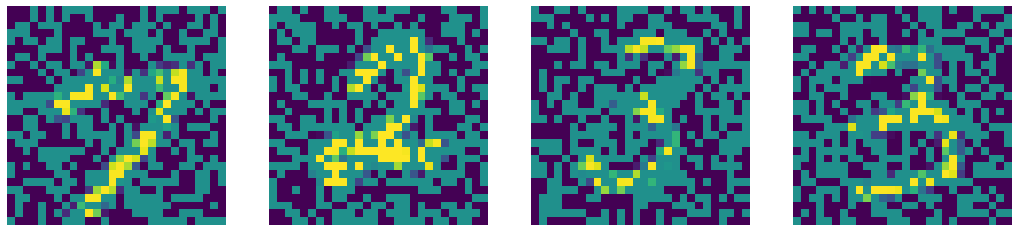

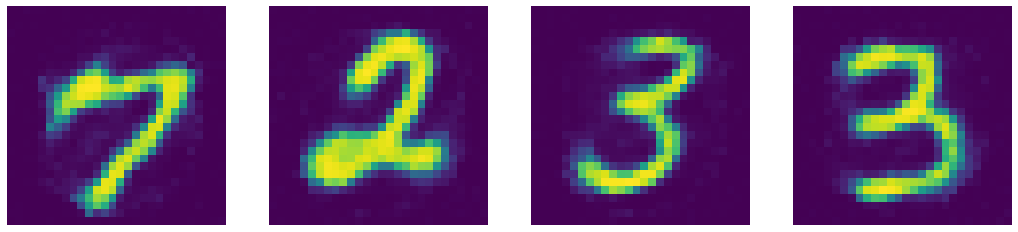

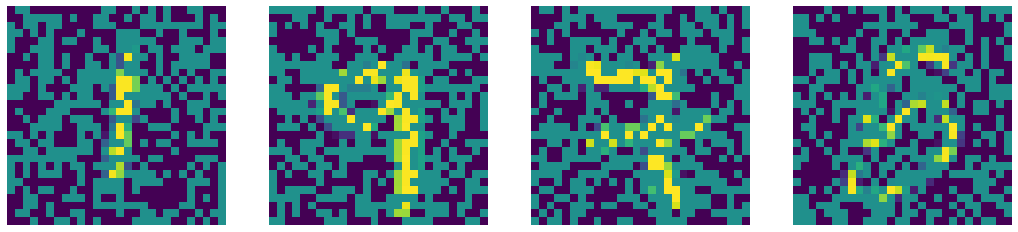

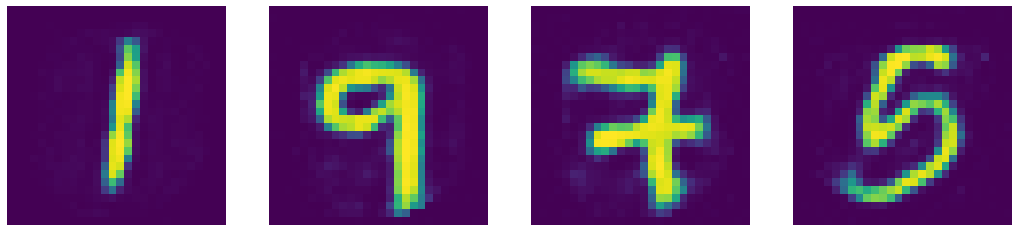

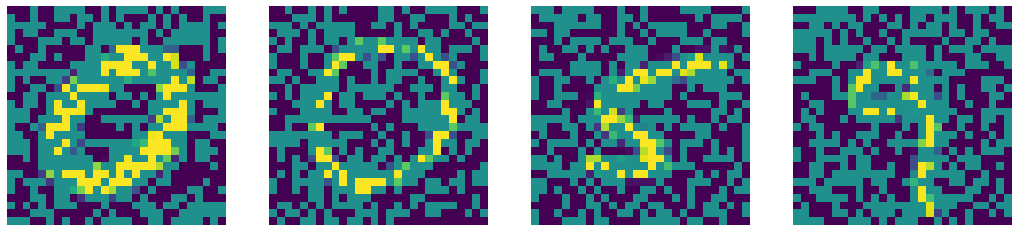

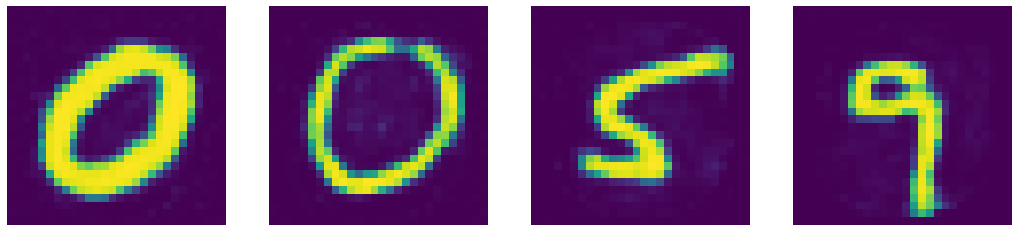

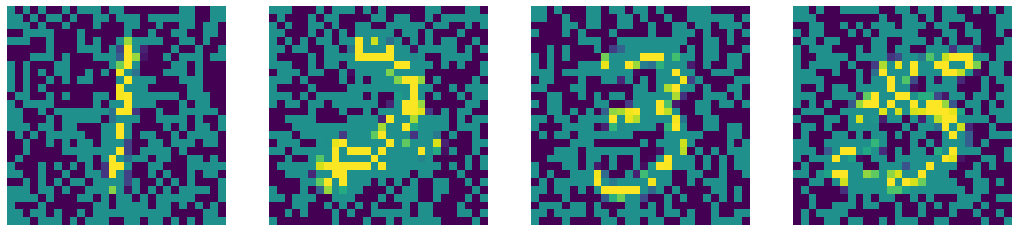

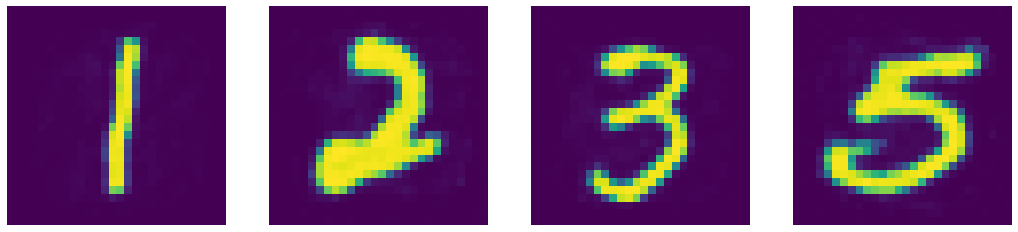

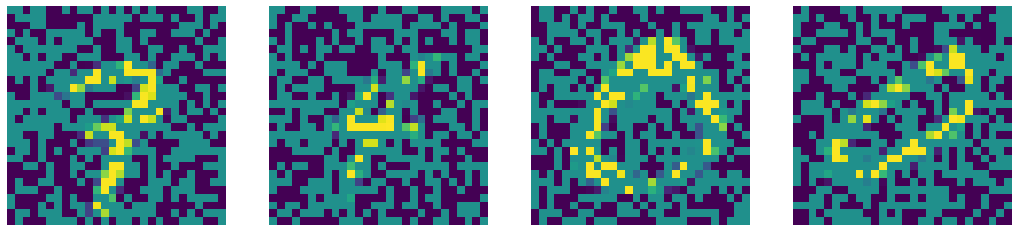

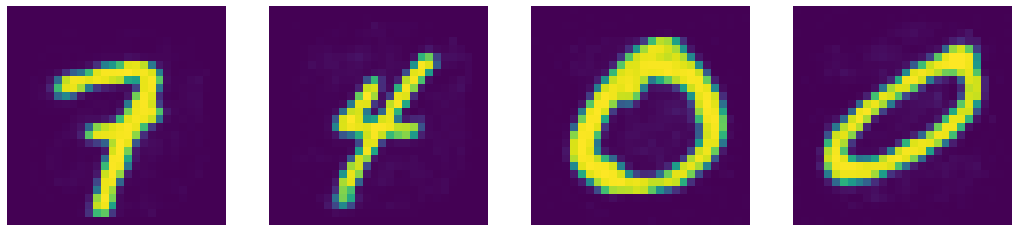

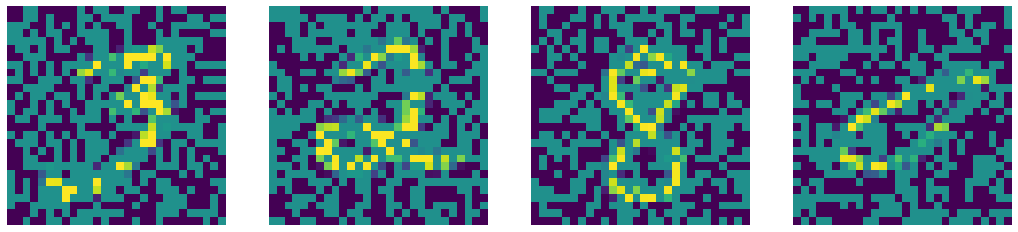

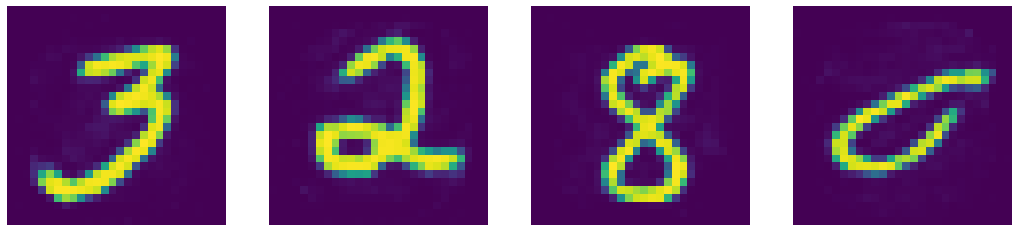

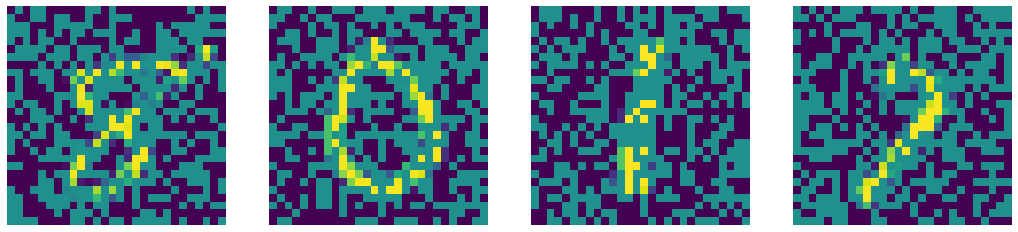

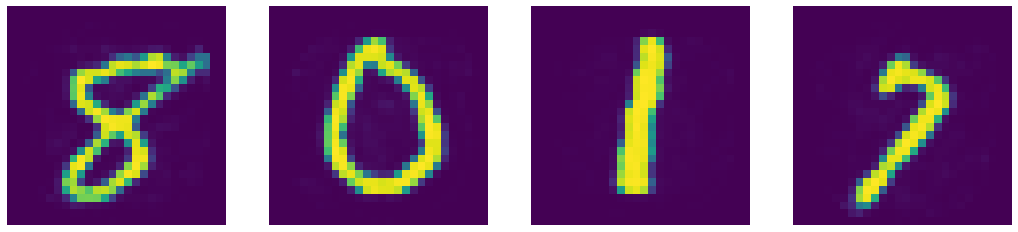

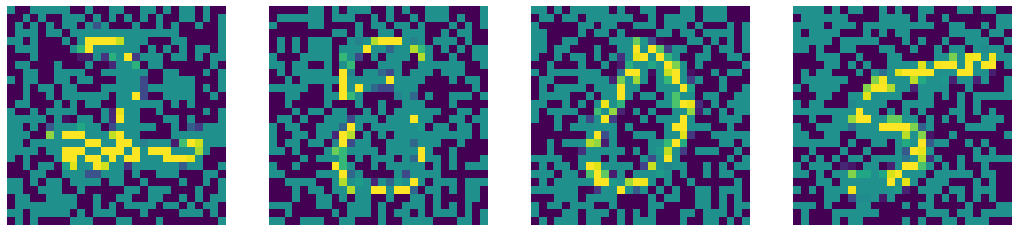

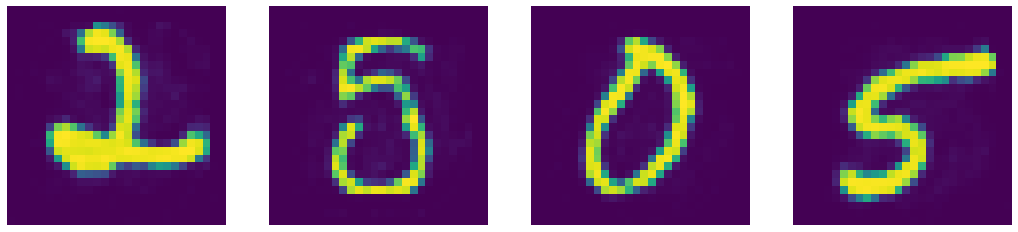

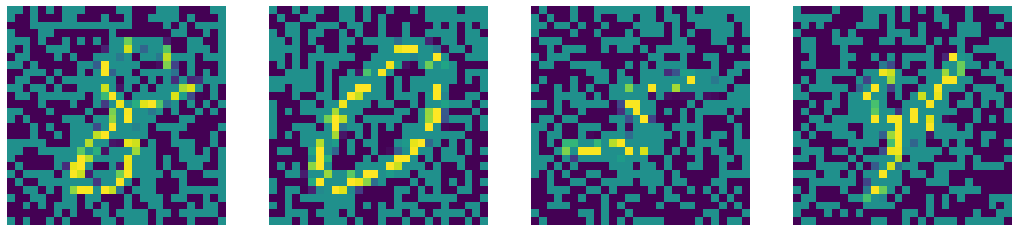

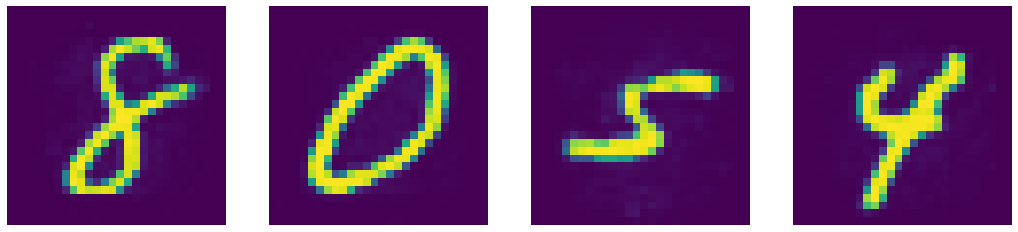

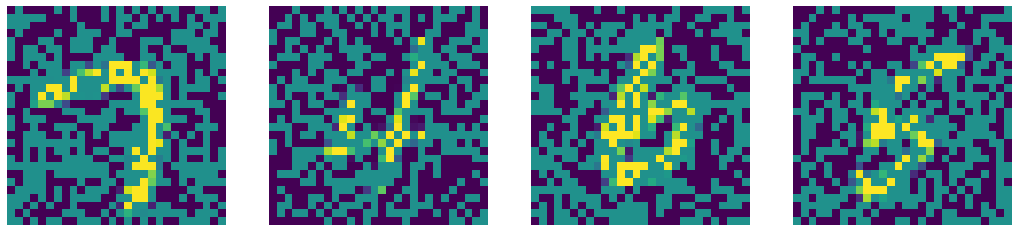

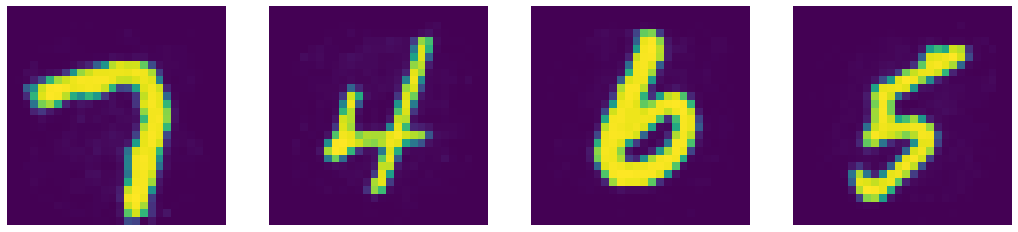

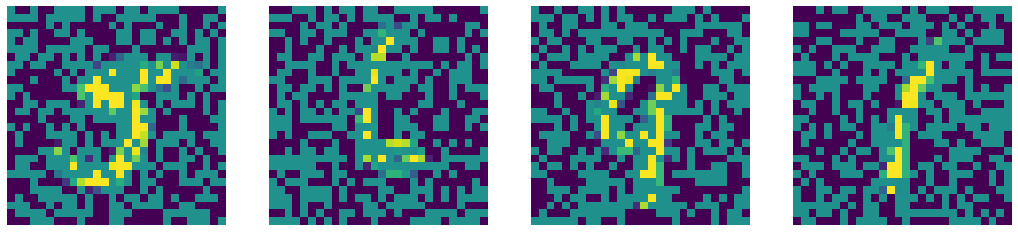

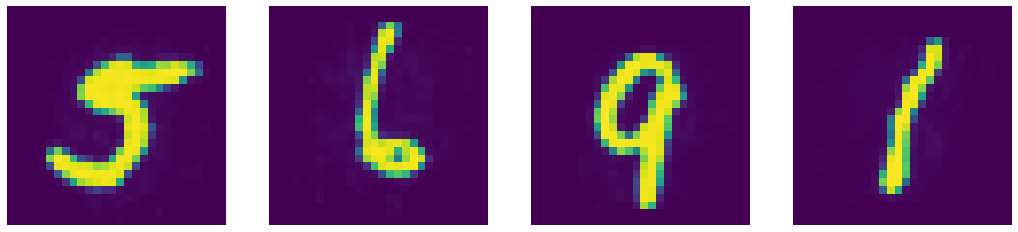

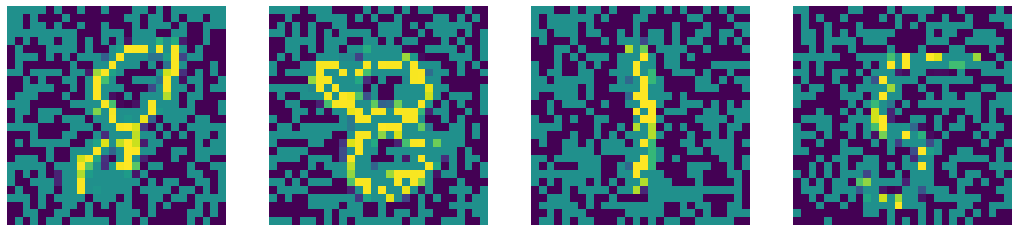

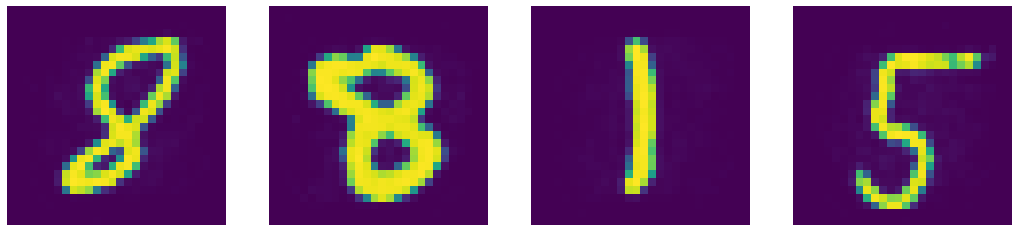

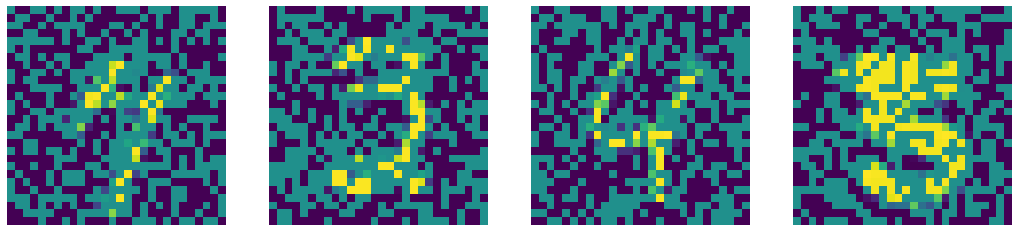

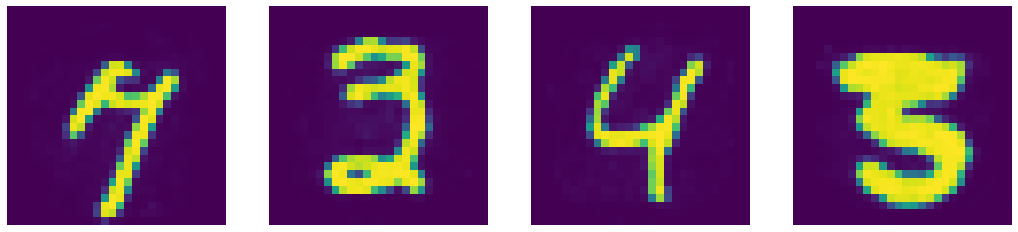

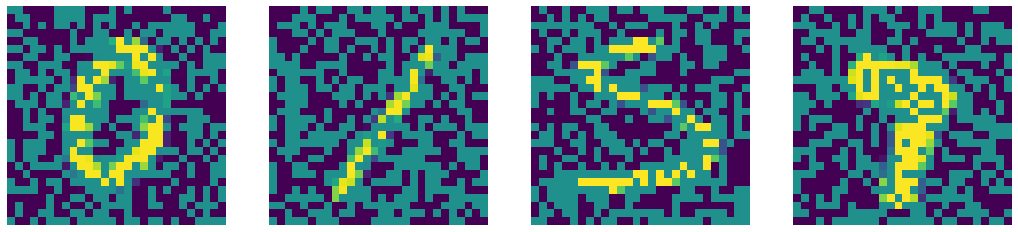

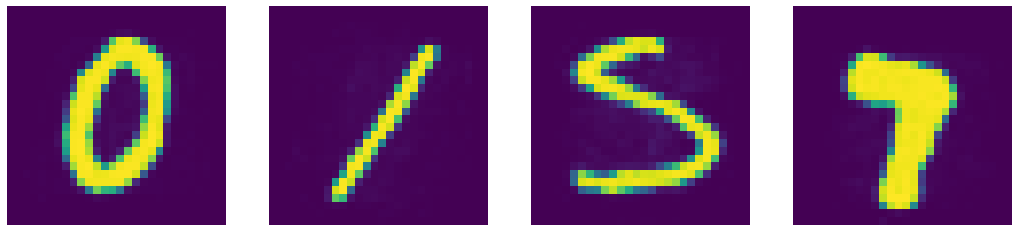

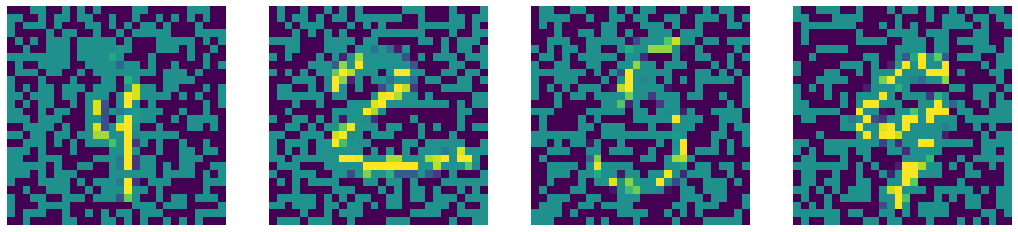

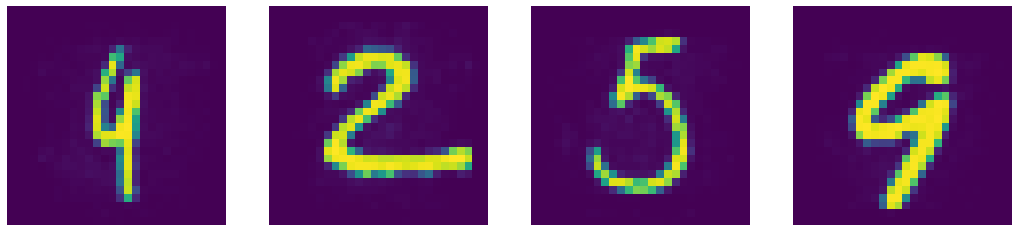

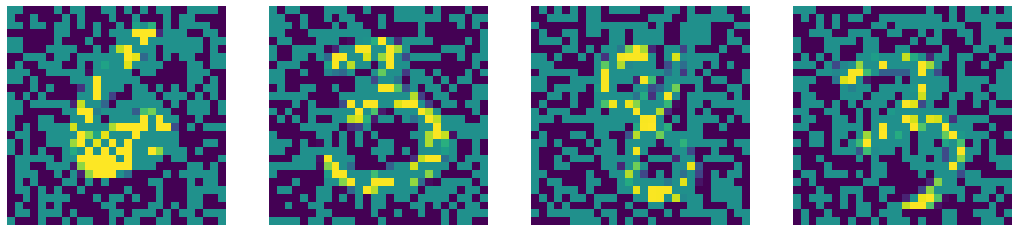

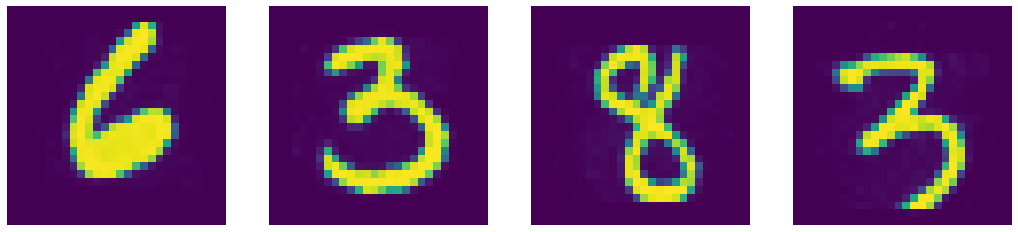

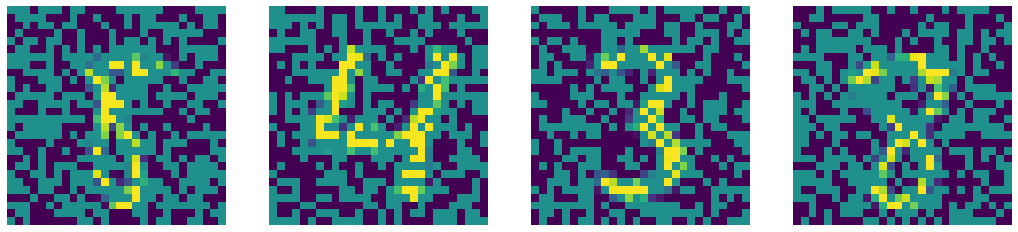

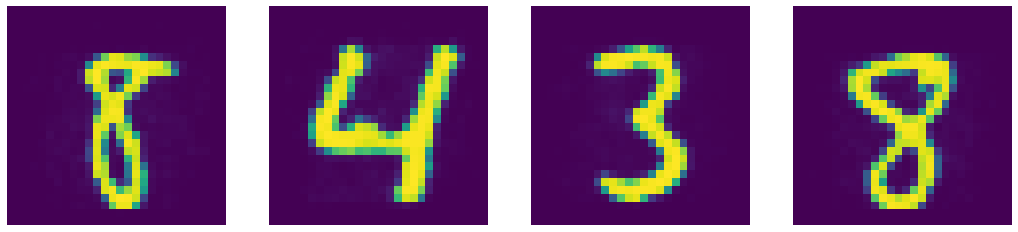

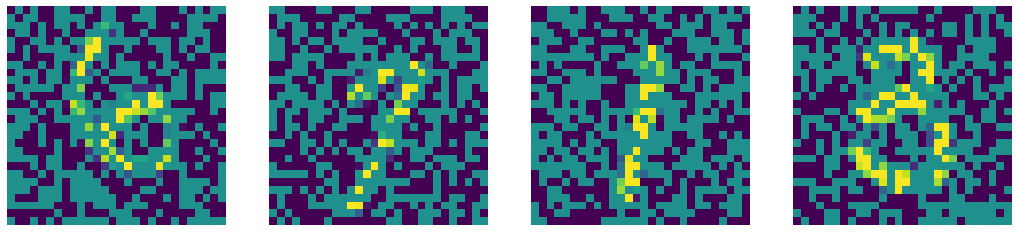

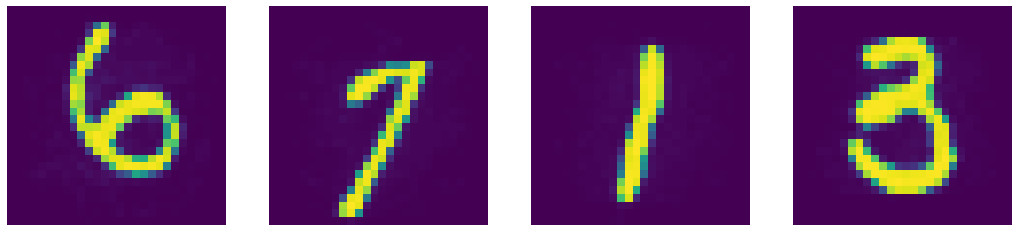

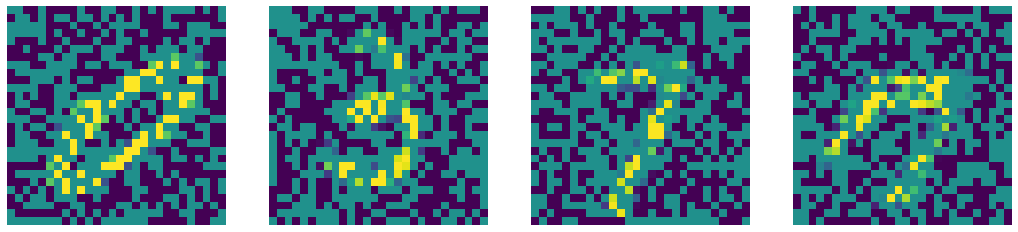

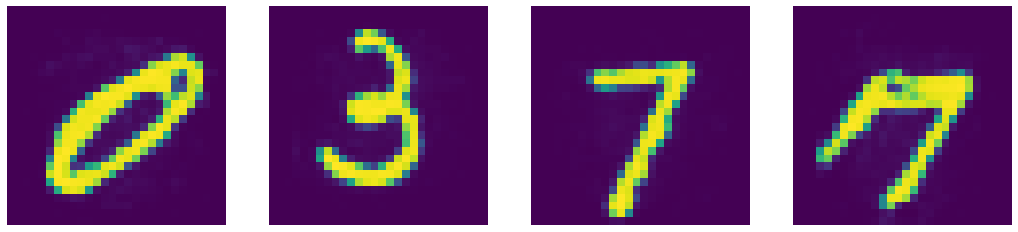

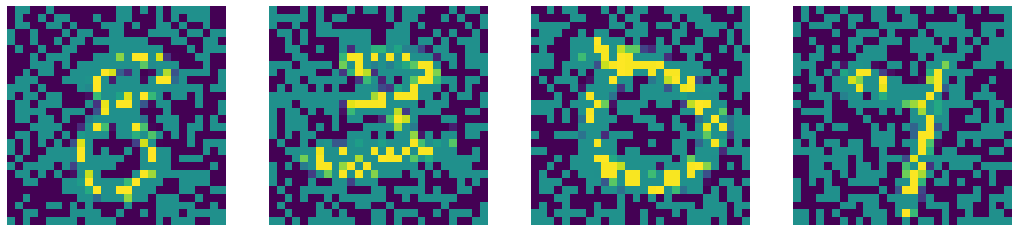

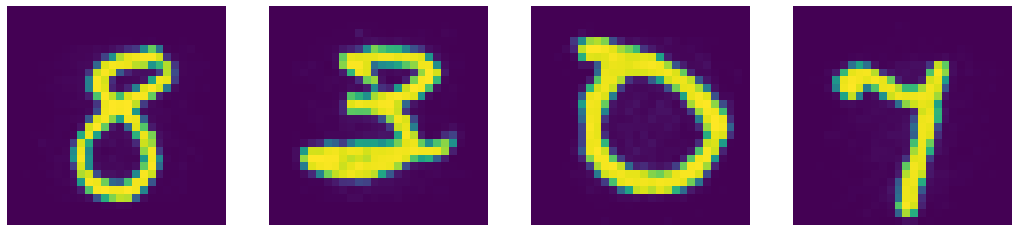

In [ ]:
num_epochs = 20
do = nn.Dropout()  # comment out for standard AE
for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = img.to(device)
        img = img.view(img.size(0), -1)
        noise = do(torch.ones(img.shape)).to(device)
        img_bad = (img * noise).to(device)  
        # ===================forward=====================
        output = model(img)  
        loss = criterion(output, img.data)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}')
    display_images(img_bad, output)  

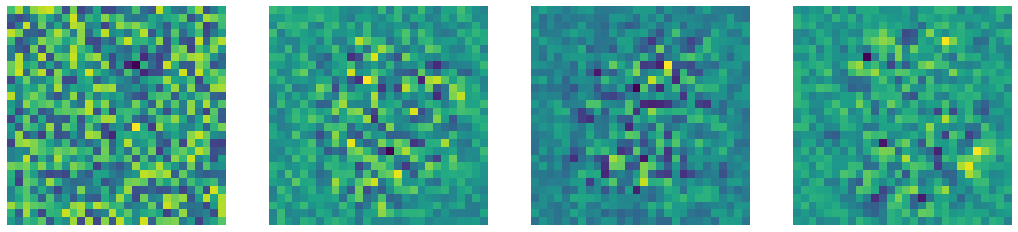

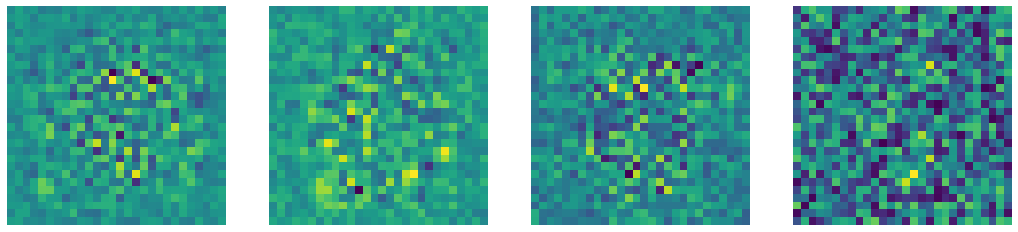

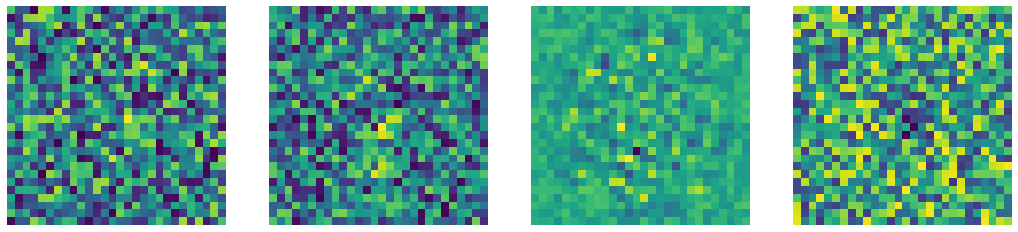

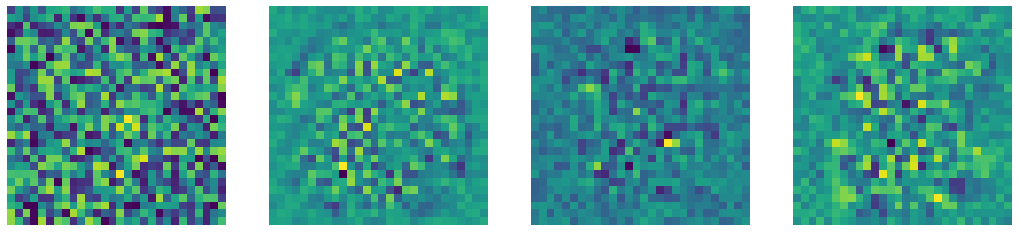

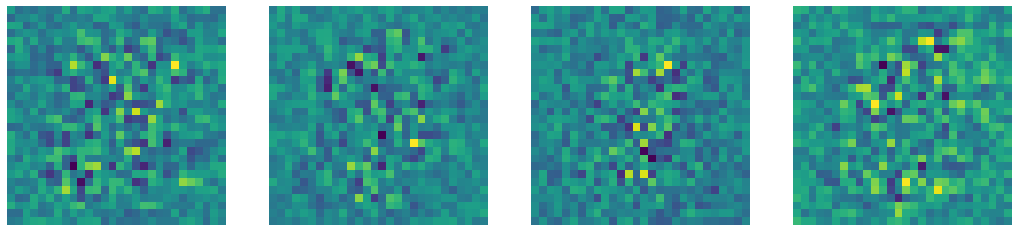

In [ ]:
display_images(None, model.enc[0].weight, 5)

In [ ]:
from cv2 import inpaint, INPAINT_NS, INPAINT_TELEA
dst_TELEA = list()
dst_NS = list()

for i in range(3, 7):
    corrupted_img = ((img_bad.data.cpu()[i].view(28, 28) / 4 + 0.5) * 255).byte().numpy()
    mask = 2 - noise.cpu()[i].view(28, 28).byte().numpy()
    dst_TELEA.append(inpaint(corrupted_img, mask, 3, INPAINT_TELEA))
    dst_NS.append(inpaint(corrupted_img, mask, 3, INPAINT_NS))

tns_TELEA = [torch.from_numpy(d) for d in dst_TELEA]
tns_NS = [torch.from_numpy(d) for d in dst_NS]

TELEA = torch.stack(tns_TELEA).float()
NS = torch.stack(tns_NS).float()

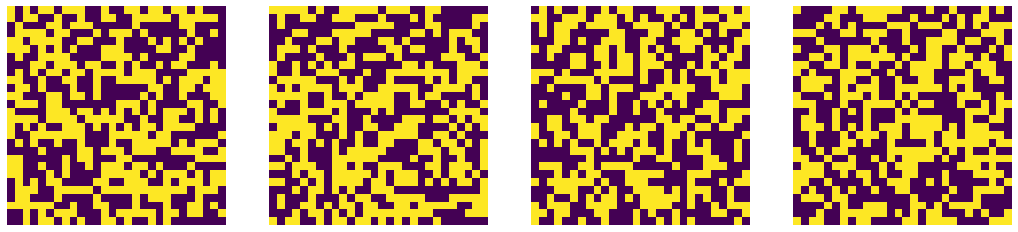

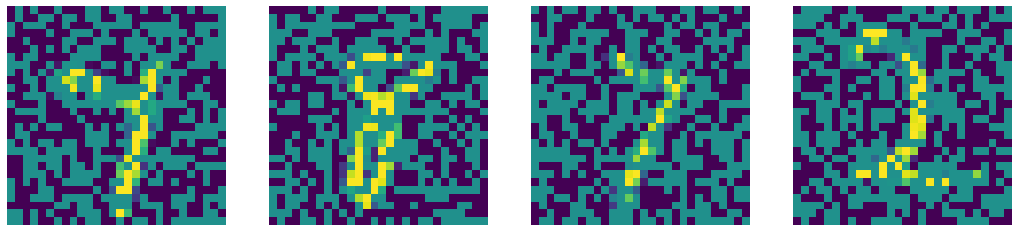

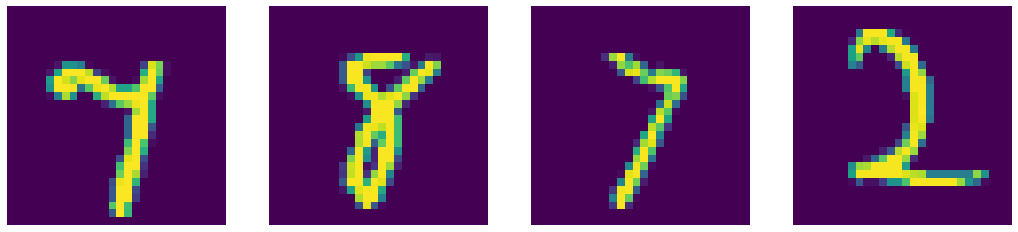

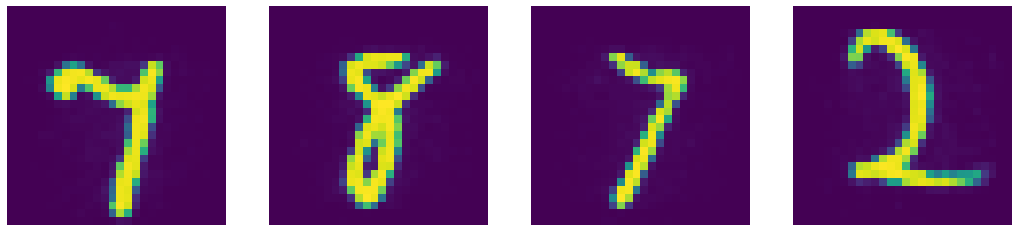

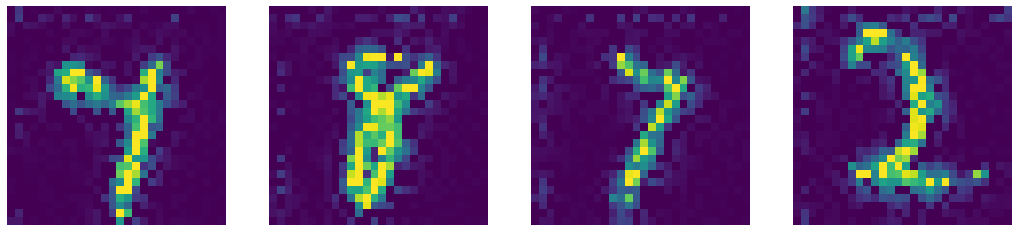

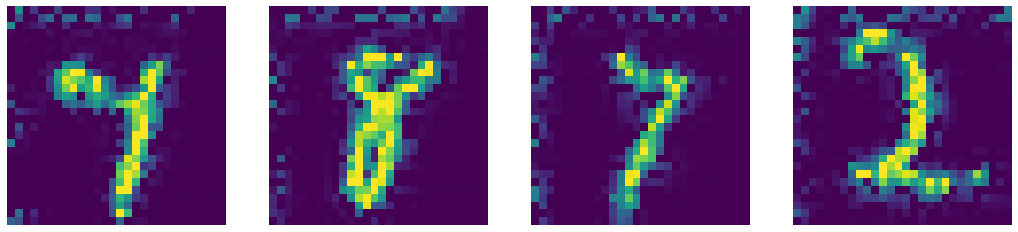

In [ ]:
with torch.no_grad():
    display_images(noise[3:7], img_bad[3:7])
    display_images(img[3:7], output[3:7])
    display_images(TELEA, NS)